In [2]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go

class DecisionTree:
    def __init__(self, max_depth=10, min_gain=0.05, max_leaf=50):
        self.max_depth = max_depth
        self.min_gain = min_gain
        self.max_leaf = max_leaf
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def predict(self, X):
        return np.array([self._predict_single(x, self.tree) for x in X])

    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        if depth >= self.max_depth or len(np.unique(y)) == 1:
            return self._create_leaf(y)

        best_split = self._find_best_split(X, y)
        if best_split['gain'] < self.min_gain:
            return self._create_leaf(y)

        left_indices = X[:, best_split['feature']] <= best_split['threshold']
        right_indices = X[:, best_split['feature']] > best_split['threshold']

        left_tree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_tree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return {
            'feature': best_split['feature'],
            'threshold': best_split['threshold'],
            'left': left_tree,
            'right': right_tree
        }

    def _find_best_split(self, X, y):
        best_split = {'gain': -1}
        n_samples, n_features = X.shape
        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                gain = self._information_gain(X[:, feature], y, threshold)
                if gain > best_split['gain']:
                    best_split = {
                        'feature': feature,
                        'threshold': threshold,
                        'gain': gain
                    }
        return best_split

    def _information_gain(self, feature_values, y, threshold):
        parent_variance = self._variance(y)
        left_indices = feature_values <= threshold
        right_indices = feature_values > threshold
        if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
            return 0

        n = len(y)
        n_left = len(y[left_indices])
        n_right = len(y[right_indices])

        var_left = self._variance(y[left_indices])
        var_right = self._variance(y[right_indices])

        child_variance = (n_left / n) * var_left + (n_right / n) * var_right
        ig = parent_variance - child_variance
        return ig

    def _variance(self, y):
        return np.var(y)

    def _create_leaf(self, y):
        return np.mean(y)

    def _predict_single(self, x, tree):
        if not isinstance(tree, dict):
            return tree
        feature = tree['feature']
        threshold = tree['threshold']
        if x[feature] <= threshold:
            return self._predict_single(x, tree['left'])
        else:
            return self._predict_single(x, tree['right'])

class RandomForest:
    def __init__(self, n_trees=10, max_depth=10, min_gain=0.1, max_leaf=200):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_gain = min_gain
        self.max_leaf = max_leaf
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for i in tqdm(range(self.n_trees), desc="Training Trees"):
            indices = np.random.choice(len(X), size=len(X), replace=True)
            X_subset, y_subset = X[indices], y[indices]
            tree = DecisionTree(max_depth=self.max_depth, min_gain=self.min_gain, max_leaf=self.max_leaf)
            tree.fit(X_subset, y_subset)
            self.trees.append(tree)

    def predict(self, X):
        tree_predictions = np.array([tree.predict(X) for tree in tqdm(self.trees, desc="Making Predictions")])
        return np.mean(tree_predictions, axis=0)

class RandomForestWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, n_trees=10, max_depth=10, min_gain=0.1, max_leaf=200):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_gain = min_gain
        self.max_leaf = max_leaf
        self.model = RandomForest(n_trees=n_trees, max_depth=max_depth, min_gain=min_gain, max_leaf=max_leaf)

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

def create_preprocessing_pipeline(continuous_features, categorical_features, n_bins=10):
    kbd = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    preprocessor = ColumnTransformer(
        transformers=[
            ('kbd', kbd, continuous_features),
            ('ohe', ohe, categorical_features)
        ],
        remainder='passthrough'
    )

    return preprocessor

def grid_search_with_cv(X, y):
    # first round of coarse grid search
    param_grid = {
        'max_depth': [10, 20, 30],
        'n_trees': [10, 30, 50]
    }

    # second round of coarse grid search
    param_grid = {
        'max_depth': [5, 10, 15],
        'n_trees': [40, 50, 60]
    }

    # third round of fine grid search
    # impact of num_trees is not significant, use simple values so n_trees=10
    param_grid = {
        'max_depth': [8, 9, 10, 11],
        'n_trees': [30]
    }

    # final model
    param_grid = {
        'max_depth': [10],
        'n_trees': [30]
    }

    best_params = None
    best_mse = float('inf')
    results = []

    kf = KFold(n_splits=5)

    for max_depth in param_grid['max_depth']:
        for n_trees in param_grid['n_trees']:
            model = RandomForest(n_trees=n_trees, max_depth=max_depth, min_gain=0.1, max_leaf=200)
            mse_scores = []

            for train_index, val_index in kf.split(X):
                X_train, X_val = X[train_index], X[val_index]
                y_train, y_val = y[train_index], y[val_index]

                model.fit(X_train, y_train)
                y_pred = model.predict(X_val)
                mse_scores.append(mean_squared_error(y_val, y_pred))

            avg_mse = np.mean(mse_scores)
            results.append((max_depth, n_trees, avg_mse))
            print(f"Params: max_depth={max_depth}, n_trees={n_trees} - MSE: {avg_mse}")

            if avg_mse < best_mse:
                best_mse = avg_mse
                best_params = (max_depth, n_trees)

    print(f"Best Params: max_depth={best_params[0]}, n_trees={best_params[1]} - MSE: {best_mse}")
    return best_params, results

def visualize_grid_search(results):
    max_depths = [r[0] for r in results]
    n_trees = [r[1] for r in results]
    mses = [r[2] for r in results]

    fig = go.Figure(data=[go.Scatter3d(
        x=max_depths, y=n_trees, z=mses,
        mode='markers',
        marker=dict(
            size=5,
            color=mses,
            colorscale='Viridis',
            colorbar=dict(title='MSE'),
            opacity=0.8
        )
    )])

    fig.update_layout(
        scene=dict(
            xaxis_title='Max Depth',
            yaxis_title='Number of Trees',
            zaxis_title='MSE'
        ),
        title='Grid Search Results'
    )

    fig.show()


Making Predictions: 100%|██████████| 30/30 [00:02<00:00, 10.81it/s]


Mean Squared Error: 2398.533359061147


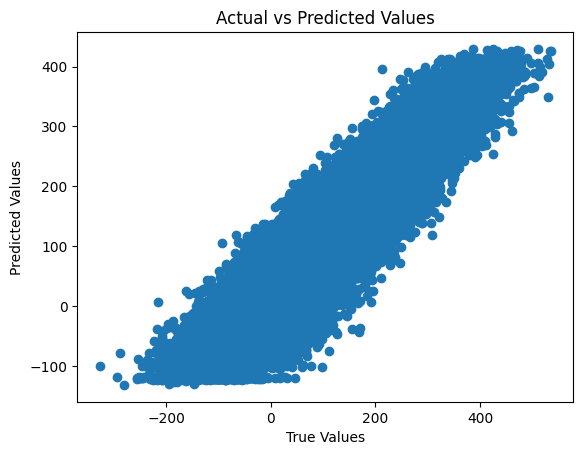

In [3]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

if __name__ == '__main__':
    # Load the pipeline
    with open('random_forest_pipeline.pkl', 'rb') as f:
        loaded_pipeline = pickle.load(f)

    # Read test data
    test_file = 'train_data2.csv'  # Specify your test data file
    df_test = pd.read_csv(test_file, index_col=0)

    X_test = df_test.drop(columns=['outcome'])
    y_true = df_test['outcome'].values

    # Predict on the test set
    y_pred = loaded_pipeline.predict(X_test)

    # Calculate the mean squared error
    mse = np.mean((y_true - y_pred) ** 2)
    print(f'Mean Squared Error: {mse}')

    # Plot actual vs predicted values
    plt.scatter(y_true, y_pred)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.show()
